In [1]:
import os
import argparse
import pickle

from joblib import Parallel, delayed
import scipy
import torch
from tqdm import tqdm

from evaluator.trajnet_evaluator import trajnet_evaluate
from evaluator.write_utils import load_test_datasets, preprocess_test, write_predictions

In [2]:
def predict_scene(predictor, model_name, paths, scene_goal, args):
    """For each scene, get model predictions"""
    paths = preprocess_test(paths, args.obs_length)
#     if 'sf_opt' in model_name:
#         predictions = predictor(paths, sf_params=[0.5, 5.0, 0.3], n_predict=args.pred_length, obs_length=args.obs_length) ## optimal sf_params (no collision constraint) [0.5, 1.0, 0.1],
    
    if  ('sf' in model_name) or ('kf' in model_name):
        predictions = predictor(paths, predict_all=args.pred_all, n_predict=args.pred_length, obs_length=args.obs_length)
    elif 'lstm_social' in model_name:
        """For each scene, get model predictions"""
        predictions = predictor(paths, scene_goal, n_predict=args.pred_length, predict_all=args.pred_all, obs_length=args.obs_length, modes=args.modes, args=args)
    elif 'lstm_physical' in model_name:
        predictions = predictor(paths, scene_goal, n_predict=args.pred_length, predict_all=args.pred_all, obs_length=args.obs_length, modes=args.modes, args=args)
    else:
        raise NotImplementedError
    return predictions


In [3]:
def load_predictor(model_name, model, device):
    """Loading the APPROPRIATE model"""
    if 'kf' in model_name:
        print("Kalman")
        from classical.kalman import predict_kf as predictor
    elif 'sf' in model_name:
        print("Social Force")
        from classical.socialforce import predict_sf as predictor
    elif 'lstm_social' in model_name:
        print("Social LSTM")
        from slstm.lstm import LSTMPredictor
        predictor = LSTMPredictor.load(model)
        predictor.model.to(device)
    elif 'lstm_physical' in model_name:
        print("Physical LSTM")
        from lstm.lstm import LSTMPredictor
        predictor = LSTMPredictor.load(model, device)
#         predictor.model.to(device)
    else:
        raise NotImplementedError
    return predictor


In [4]:
def get_predictions(args):
    """Get model predictions for each test scene and write the predictions in appropriate folders"""
    ## List of .json file inside the args.path (waiting to be predicted by the testing model)
    datasets = sorted([f.split('.')[-2] for f in os.listdir(args.path.replace('_pred', '')) if not f.startswith('.') and f.endswith('.ndjson')])

    ## Handcrafted Baselines (if included)
    if args.kf:
        args.output.append('/kf.pkl')
    if args.sf:
        args.output.append('/sf.pkl')


    ## Extract Model names from arguments and create its own folder in 'test_pred' for storing predictions
    ## WARNING: If Model predictions already exist from previous run, this process SKIPS WRITING
    for model in args.output:
        model_name = model.split('/')[-1].replace('.pkl', '')
        model_name = model_name + '_modes' + str(args.modes)

        ## Check if model predictions already exist
        if not os.path.exists(args.path):
            os.makedirs(args.path)
        if not os.path.exists(args.path + model_name):
            os.makedirs(args.path + model_name)
        else:
            print('Predictions corresponding to {} already exist.'.format(model_name))
            print('Loading the saved predictions')
            continue

        print("Model Name: ", model_name)
        predictor = load_predictor(model_name, model, args.device)
        goal_flag = False

        # Iterate over test datasets
        for dataset in datasets:
            # Load dataset
            dataset_name, scenes, scene_goals = load_test_datasets(dataset, goal_flag, args)

        
            # Get all predictions in parallel. Faster!
#             scenes = scenes[:args.len]
            scenes = tqdm(scenes)

            pred_list = Parallel(n_jobs=4)(delayed(predict_scene)(predictor, model_name, paths, scene_goal, args)
                                            for (_, _, paths), scene_goal in zip(scenes, scene_goals))

#             pred_list = []
#             for (scene, scene_goal) in zip(scenes, scene_goals):
#                 _, _, paths = scene
#                 pred = predict_scene(predictor, model_name, paths, scene_goal, args)
#                 pred_list.append(pred)

            # Write all predictions
            write_predictions(pred_list, scenes, model_name, dataset_name, args)


In [5]:
def main(args):
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--path', default='trajdata',
#                         help='directory of data to test')
#     parser.add_argument('--output', nargs='+',
#                         help='relative path to saved model')
#     parser.add_argument('--obs_length', default=25, type=int,
#                         help='observation length')
#     parser.add_argument('--pred_length', default=25, type=int,
#                         help='prediction length')
#     parser.add_argument('--write_only', action='store_true',
#                         help='disable writing new files')
#     parser.add_argument('--disable-collision', action='store_true',
#                         help='disable collision metrics')
#     parser.add_argument('--labels', required=False, nargs='+',
#                         help='labels of models')
#     parser.add_argument('--normalize_scene', action='store_true',
#                         help='augment scenes')
#     parser.add_argument('--modes', default=1, type=int,
#                         help='number of modes to predict')
#     parser.add_argument('--sf', action='store_true',
#                         help='consider socialforce in evaluation')
#     parser.add_argument('--orca', action='store_true',
#                         help='consider orca in evaluation')
#     parser.add_argument('--kf', action='store_true',
#                         help='consider kalman in evaluation')
#     parser.add_argument('--cv', action='store_true',
#                         help='consider constant velocity in evaluation')
#     args = parser.parse_args()

    scipy.seterr('ignore')

#     args.output = []
    ## assert length of output models is not None
    if (not args.sf) and (not args.kf):
        assert 'No handcrafted baseline mentioned'

    args.output = args.output if args.output is not None else []
    
    args.path = 'DATA_BLOCK/' + args.path + '/test_pred/'

    ## Writes to Test_pred
    ## Does NOT overwrite existing predictions if they already exist ###
    get_predictions(args)
    if args.write_only: # For submission to AICrowd.
        print("Predictions written in test_pred folder")
        exit()
    ## Evaluate using TrajNet++ evaluator
    trajnet_evaluate(args)


In [8]:
class Args:
    def __init__(self):
        self.path = 'cars'
        self.output = []
        self.obs_length = 25
        self.pred_length = 25
        self.write_only = False
        self.disable_collision = False
        self.labels = None
        self.normalize_scene = False
        self.modes = 1
        self.sf = False
        self.kf = False
#         self.len = 1000
        self.pred_all = False
        self.device = torch.device('cpu')

args = Args()


C:\Users\Administrator\AppData\Local\Temp\ipykernel_6332\1411156621.py:31: DeprecationWarning: scipy.seterr is deprecated and will be removed in SciPy 2.0.0, use numpy.seterr instead
  scipy.seterr('ignore')


Predictions corresponding to lstm_social_None_modes1 already exist.
Loading the saved predictions
Predictions corresponding to lstm_physical_None_modes1 already exist.
Loading the saved predictions
Model Name:  kf_modes1
Kalman
Dataset Name:  highD_tracks.ndjson


100%|██████████████████████████████████████████████████████████████████████████████| 1064/1064 [02:10<00:00,  8.16it/s]


Dataset Name:  inD_tracks.ndjson


100%|██████████████████████████████████████████████████████████████████████████████| 5190/5190 [09:25<00:00,  9.17it/s]


lstm_social_None_modes1
['highD_tracks.ndjson', 'inD_tracks.ndjson']
pred_datasets:  ['DATA_BLOCK/cars/test_pred/lstm_social_None_modes1/highD_tracks.ndjson', 'DATA_BLOCK/cars/test_pred/lstm_social_None_modes1/inD_tracks.ndjson']
true_datasets:  ['DATA_BLOCK/cars/test_private/highD_tracks.ndjson', 'DATA_BLOCK/cars/test_private/inD_tracks.ndjson']
lstm_physical_None_modes1
['highD_tracks.ndjson', 'inD_tracks.ndjson']
pred_datasets:  ['DATA_BLOCK/cars/test_pred/lstm_physical_None_modes1/highD_tracks.ndjson', 'DATA_BLOCK/cars/test_pred/lstm_physical_None_modes1/inD_tracks.ndjson']
true_datasets:  ['DATA_BLOCK/cars/test_private/highD_tracks.ndjson', 'DATA_BLOCK/cars/test_private/inD_tracks.ndjson']
kf_modes1
['highD_tracks.ndjson', 'inD_tracks.ndjson']
pred_datasets:  ['DATA_BLOCK/cars/test_pred/kf_modes1/highD_tracks.ndjson', 'DATA_BLOCK/cars/test_pred/kf_modes1/inD_tracks.ndjson']
true_datasets:  ['DATA_BLOCK/cars/test_private/highD_tracks.ndjson', 'DATA_BLOCK/cars/test_private/inD_track

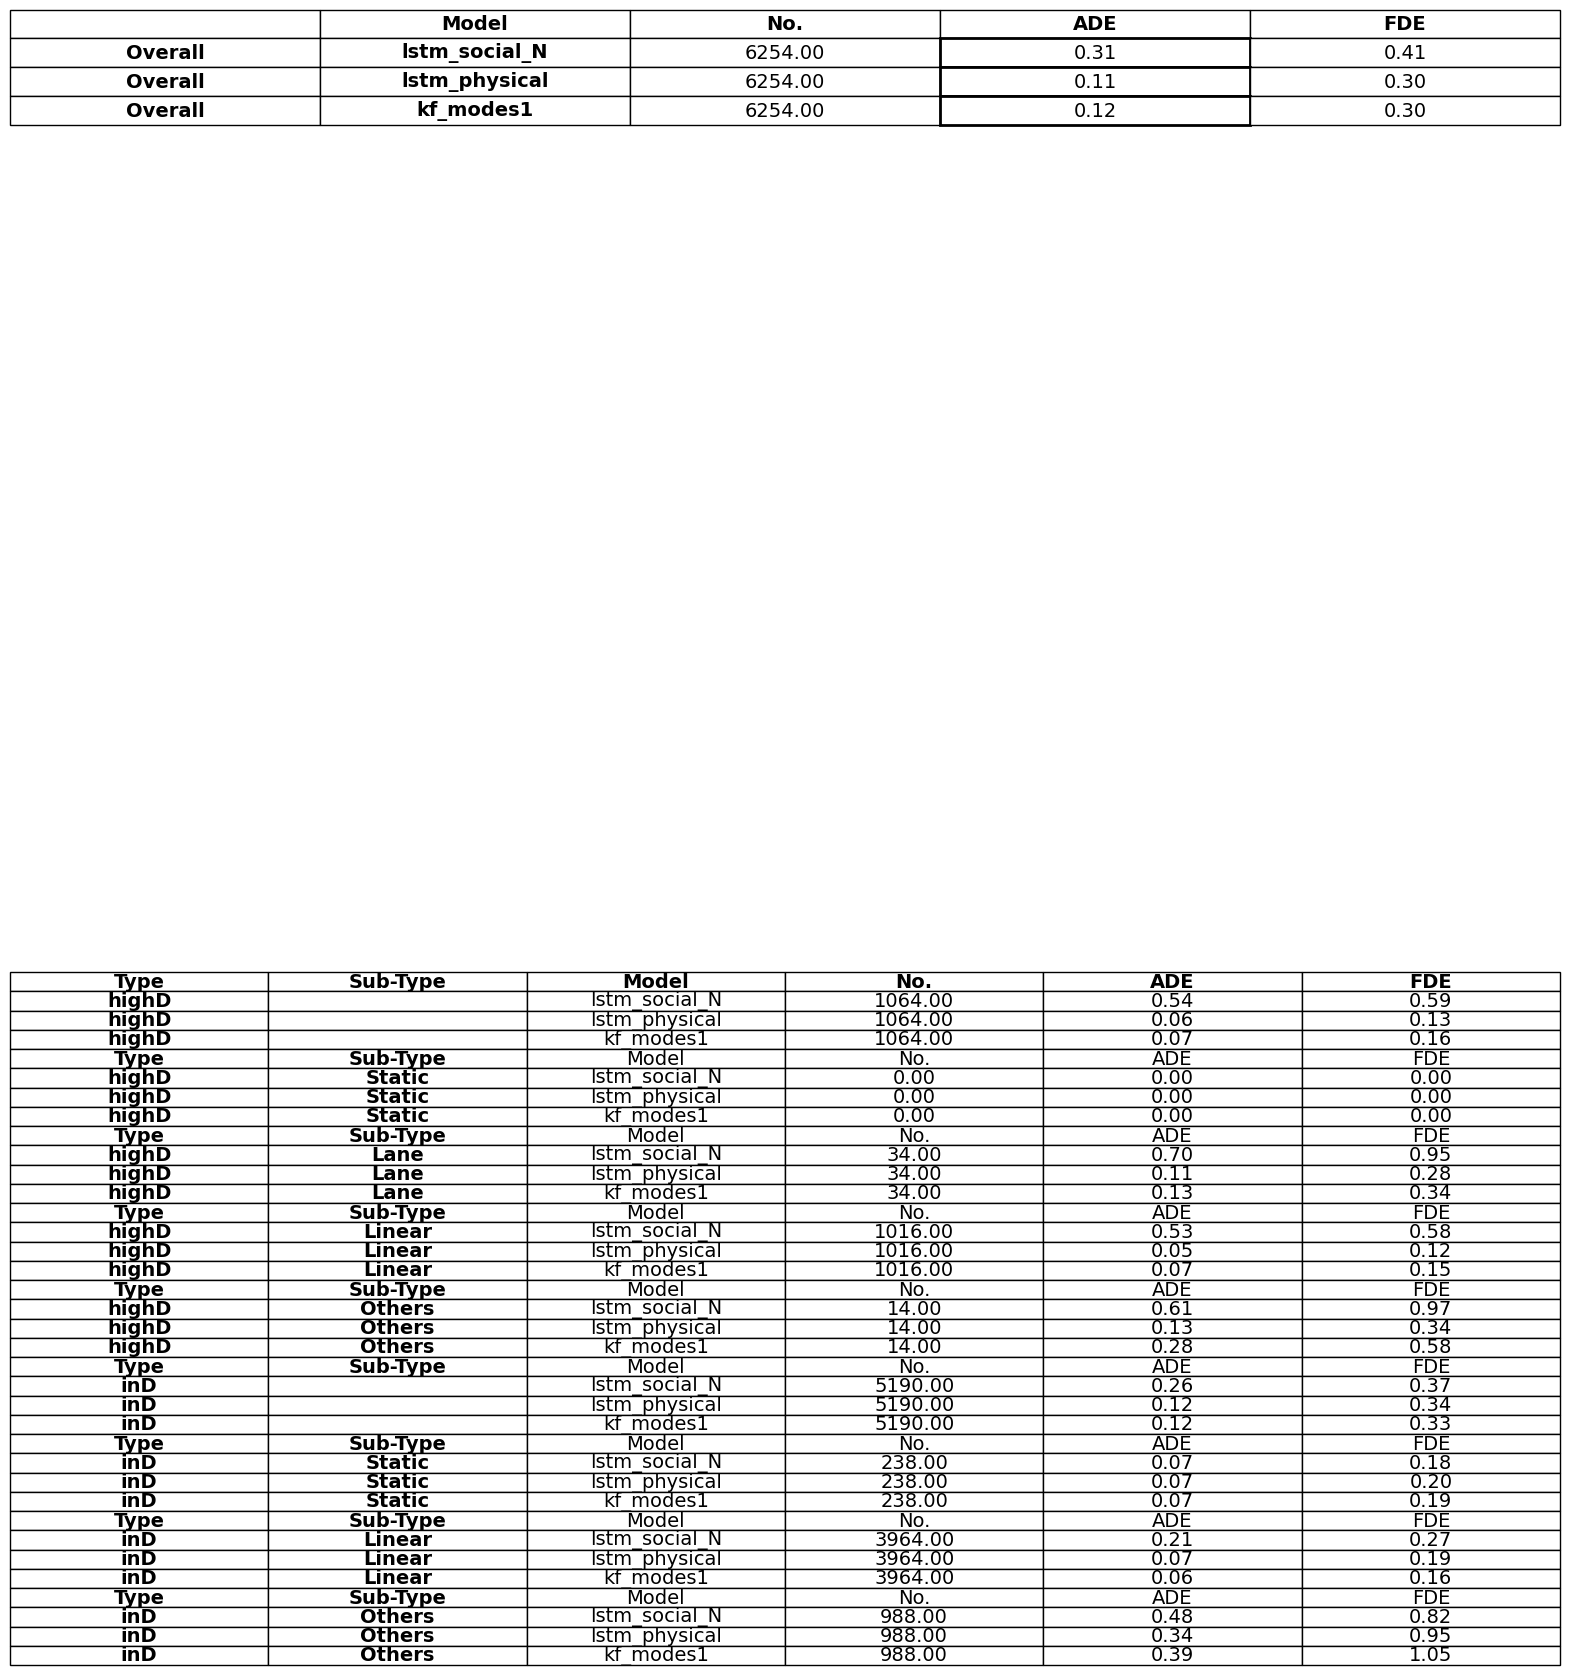

In [9]:
if __name__ == '__main__':
    args.output = ['OUTPUT_BLOCK/cars/lstm_social_None.pkl', 'OUTPUT_BLOCK/cars/lstm_physical_None.pkl']
#     args.sf = 1
    args.kf = 1

    main(args)